# 分子の比熱を計算するスクリプト
* gen_lammps_inputs.ipynb
1. SMILESから分子生成
2. LigParGenからOPLS取得
3. OPLS formatのチェック・修正
4. PFP-tuned OPLSの取得
5. LAMMPS入力ファイルの生成

* setup_lammps.ipynb
6. LAMMPS実行フォルダの作成
7. SMILES、JOB番号、生成日時、LAMMPS設定をメタデータとして保存
8. LAMMPS入力ファイルを実行フォルダにコピー
9. LAMMPS実行スクリプトの生成

* run.ipynb
10. LAMMPS実行
11. LAMMPS終了の確認、異常終了-> 12､正常終了->13
12. エラーの確認、原因を出力して終了（LAMMPS入力を修正して再実行）
13. LAMMPS出力ファイルの読み込み、解析用データの保存

* analyze.ipynb
14. LAMMPS計算から比熱の計算
15. 計算結果の解析



In [1]:
import os
import sys
import shutil
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interactive

cwd = os.getcwd()
rootdir = cwd.rsplit("jobs", 1)[0]
modulepaths = [os.path.join(rootdir, "nbpackage")]
print(modulepaths)
sys.path.extend(modulepaths)
import nbpackage
from nbpackage.AN import pfp
from nbpackage.AN import opt
from nbpackage.AN import ioutils
from nbpackage.AN import rwmol
from nbpackage.AN import md
from nbpackage.AN.view import view_molecule

import ase
from ase import Atoms, units
from ase.io import read, Trajectory
from ase.constraints import ExpCellFilter
from ase.visualize import view
from ase.optimize import BFGS

import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
#from importlib import reload


['/Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage']
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/pfp.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/opt.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/ioutils.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/rwmol.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/md/ligpargen.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpackage/nbpackage/nbpackage/AN/md/lammps.ipynb
importing Jupyter notebook from /Users/akihiro/Documents/200_仕事/CODEs/20220531_nbpackage/nbpacka

1. SMILESから分子生成

Convert SMILES to canonical representations.
['CCCCCOS(=O)OCCCCC', 'CC/C=C\\CCOC(=O)CCCCC', 'CC(=O)OCC=C(C)CCC=C(C)C', 'C=C(C)C(=O)OCC(CC)CCCC', 'CC1=CC(=O)C2CC1C2(C)C']


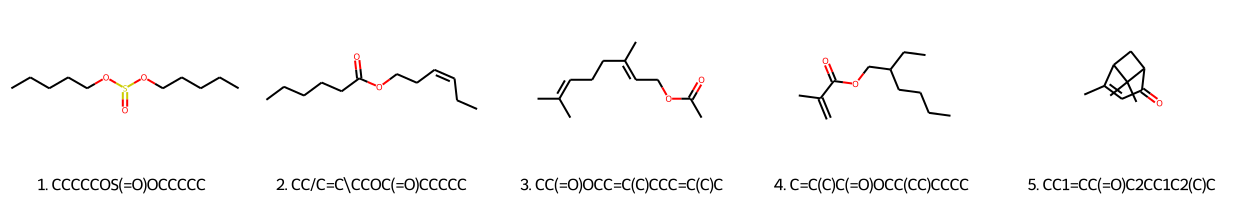

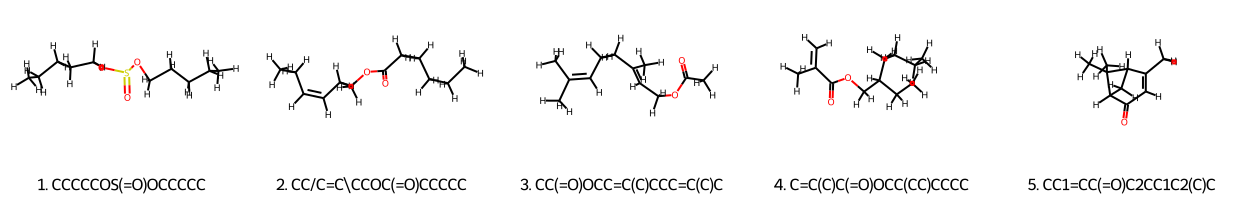

In [2]:
savedir = 'PDB'
smileses = ["CCCCCOS(=O)OCCCCC", "CCCCCC(=O)OCC/C=C\CC", "CC(C)=CCCC(C)=CCOC(=O)C", "CC(=C)C(=O)OCC(CC)CCCC", "CC1(C)C2C(C)=CC(=O)C1(C2)"]
rwmols = rwmol.get_rwmol_from_smiles(smiles=smileses, add_Hs=False, add_conformer=False)
smileses = [Chem.MolToSmiles(Chem.RemoveAllHs(_), canonical=True) for _ in rwmols]
print('Convert SMILES to canonical representations.')
print(smileses)
labels = [str(i+1) for i in range(len(smileses))]

_subImgSize = (250, 200)
_legends = [f'{l}. {s}' for l,s in zip(labels, smileses)]
_molsPerRow = min(8, len(smileses))
_view = Draw.MolsToGridImage(rwmols, subImgSize=_subImgSize, molsPerRow=_molsPerRow, legends=_legends)
display(_view)
      
rwmols = rwmol.get_rwmol_from_smiles(smiles=smileses, add_Hs=True, add_conformer=True)
_view = Draw.MolsToGridImage(rwmols, subImgSize=_subImgSize, molsPerRow=_molsPerRow, legends=_legends)
display(_view)
for l, m in zip(labels, rwmols):
    _filename = os.path.join(savedir, f'{l}.pdb')
    Chem.MolToPDBFile(m, _filename)

2. LigParGenからOPLS取得

In [3]:

lammpsdatafiles_ligpargen = []
savedir = 'ligpargen_data'
if not os.path.exists(savedir):
    os.makedirs(savedir)

for i, s in enumerate(smileses):
    _filename = os.path.join(savedir, f"{i}.data")
    if os.path.exists(_filename):
        lammpsdatafiles_ligpargen.append(_filename)
        continue

    ligpargen = md.LigParGen()
    try:
        print(f'Sending smiles {s} to the LigPraGen server...')
        ligpargen.get_opls_from_smiles(smiles=s, format="lammps")  #  , to=_filename)
    except Exception as p:
        print(p)
        lammpsdatafiles_ligpargen.append(None)
        continue

    _filename_ligpargen = glob.glob('UNK_*.lmp')[0] ## filename should be read in the LigParGen web site.
    print(f'Save lammps data to {_filename}' )
    shutil.move(_filename_ligpargen, _filename)
    lammpsdatafiles_ligpargen.append(_filename)
print(lammpsdatafiles_ligpargen)


['ligpargen_data/0.data', 'ligpargen_data/1.data', 'ligpargen_data/2.data', 'ligpargen_data/3.data', 'ligpargen_data/4.data']


3. OPLSフォーマットの確認・修正 

In [4]:
lammpsdatafiles_ligpargen

['ligpargen_data/0.data',
 'ligpargen_data/1.data',
 'ligpargen_data/2.data',
 'ligpargen_data/3.data',
 'ligpargen_data/4.data']

In [5]:
lammps = md.Lammps()
lammpsdatafiles = []
_comment_ligpargen = "LAMMPS data file Created by LigParGen - (Written by Leela S. Dodda)"

for _filename, _smiles in zip(lammpsdatafiles_ligpargen, smileses):

    _savedir = os.path.dirname(_filename)
    if not os.path.exists(_savedir):
        os.makedirs(_savedir)

    _basename = os.path.basename(_filename)
    _basename, _ext = os.path.splitext(_basename)
    _bkupfilename = os.path.join(_savedir, f'{_basename}_ligpargen{_ext}')
    if os.path.exists(_filename) and os.path.exists(_bkupfilename):
        print(f'{_bkupfilename} exist. skip checking lammps format.')
        lammpsdatafiles.append(_filename)
        continue

    _comment = f"LAMMPS data file via SMILES {_smiles}"
    _lines = lammps.check_ligpargen_format(_filename)
    _lines = _lines.replace(_comment_ligpargen, _comment)
    
    os.rename(_filename, _bkupfilename)
    with open(_filename, "w") as g:
        g.write(_lines)
    lammpsdatafiles.append(_filename)
print(lammpsdatafiles)


ligpargen_data/0_ligpargen.data exist. skip checking lammps format.
ligpargen_data/1_ligpargen.data exist. skip checking lammps format.
ligpargen_data/2_ligpargen.data exist. skip checking lammps format.
ligpargen_data/3_ligpargen.data exist. skip checking lammps format.
ligpargen_data/4_ligpargen.data exist. skip checking lammps format.
['ligpargen_data/0.data', 'ligpargen_data/1.data', 'ligpargen_data/2.data', 'ligpargen_data/3.data', 'ligpargen_data/4.data']


4. PFP-tuned OPLS取得

In [6]:
_savedir = 'tunedOPLS'
_filenames = []
if not os.path.exists(_savedir):
    os.mkdir(_savedir)
for _filename in lammpsdatafiles:
    _basename = os.path.basename(_filename)
    #_basename, _ext = os.path.splitext(_filename)
    _savefilename = os.path.join(_savedir, _basename)
    md.refine_opls_via_pfp(_filename, to=_savefilename)
    _filenames.append(_savefilename)
lammpsdatafiles = _filenames

5. LAMMPS入力ファイルの作成

In [7]:
atomses = [read(_, format='lammps-data') for _ in lammpsdatafiles]
_atomses = []
for m, a in zip(rwmols, atomses):
    _numbers = [_.GetAtomicNum() for _ in m.GetAtoms()]
    a.set_atomic_numbers(_numbers)
    _atomses.append(Atoms(numbers=a.numbers, positions=a.positions, pbc=True, cell=a.cell))
print(_atomses)


[Atoms(symbols='C5OSO2C5H22', pbc=True, cell=[50.0, 50.0, 50.0]), Atoms(symbols='C6OCOC5H22', pbc=True, cell=[50.0, 50.0, 50.0]), Atoms(symbols='C2O2C10H20', pbc=True, cell=[50.0, 50.0, 50.0]), Atoms(symbols='C4O2C8H22', pbc=True, cell=[50.0, 50.0, 50.0]), Atoms(symbols='C4OC6H14', pbc=True, cell=[50.0, 50.0, 50.0])]


In [8]:
def view_molecule(filename, view_type):
    print(view_type)
    if isinstance(filename, str):
        basename, ext = os.path.splitext(filename)
        if ext == '.data':
            format = 'lammps-data'
        else:
            format = ext.lstrip('.')

            mol = read(filename, format=format)
    elif isinstance(filename, Atoms):
        mol = filename
    elif isinstance(filename, PosixPath):
        ext = filename.suffix
        print(ext)
        if ext=='.data':
            format = 'lammps-data'
        else:
            format = str(ext).lstrip('.')
        mol = read(str(filename), format=format)
    else:
        print(filename, type(filename))
    v = view(mol, viewer='ngl')
    v.view.add_representation(view_type)
    print(str(filename))
    display(v)

def view_molecules(path_files, view_type=['ball+stick', 'distance', 'hyperball', 'label', 'licorice', 'line', 'spacefill', 'surface'], height='600px'):
    interactive_view = interactive(view_molecule, filename=path_files, view_type=view_type)
    output = interactive_view
    output.layout.height = height
    return interactive_view

In [9]:
view_molecules(_atomses)

interactive(children=(Dropdown(description='filename', options=(Atoms(symbols='C5OSO2C5H22', pbc=True, cell=[5…

ball+stick
Atoms(symbols='C5OSO2C5H22', pbc=True, cell=[50.0, 50.0, 50.0])
